In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json

In [2]:
orders = pd.read_csv('orders.csv')
sales = pd.read_csv('sales.csv')
user = pd.read_csv('user.csv')
store = pd.read_csv('store.csv')
product = pd.read_csv('product.csv')

In [3]:
# В данных столбец orders['product_info'] представлен в некорректном формате. Формат JSON предполагает, что строка
# заключена в двойные кавычки, а не одинарные, а также, True и False должны быть написаны с маленькой буквы
# иначе мы просто не сможем корректно считать json-строку. Исправим это:
orders['product_info'] = orders['product_info'].replace('\'', '"', regex=True).replace('True', 'true', regex=True).replace('False', 'false', regex=True)
orders['product_info'] = orders['product_info'].apply(json.loads)
new_ord = orders.explode('product_info')
new_ord = new_ord.reset_index(drop=True)
orders = pd.concat([new_ord, pd.DataFrame(new_ord['product_info'].tolist())], axis=1)
del new_ord
del orders['product_info']
del sales['id']

In [4]:
#Посчитаем общую сумму продаж
orders['prod_amount'] = orders['product_price'] * orders['count']
orders = pd.merge(orders, sales[['order_id', 'product_id', 'is_canceled', 'is_accepted']], on=['order_id', 'product_id'])
orders = orders[(orders['is_canceled'] == False) & (orders['is_accepted'] == True)]
total = orders['prod_amount'].sum()


#Общая прибыль с продаж
orders['profit'] = orders['product_comission'] * orders['count']
total_profit = orders['profit'].sum()


#Посчитаем средний чек:
avg_order = orders.groupby('order_id')['prod_amount'].sum().mean()


#Посчитаем распределение среднего чека по магазинам
orders = pd.merge(orders, store, on='store_id')
avg_order_shop = orders.groupby(['store_name', 'order_id'])['prod_amount'].sum().reset_index().groupby('store_name')['prod_amount'].mean().reset_index()


print(f'Общая сумма продаж - {round(total):,d} руб.')
print(f'Общая прибыль - {round(total_profit):,d} руб.')
print(f'Средний чек - {round(avg_order):,d} руб.')

Общая сумма продаж - 22,032,716,172 руб.
Общая прибыль - 2,991,609,825 руб.
Средний чек - 39,252 руб.


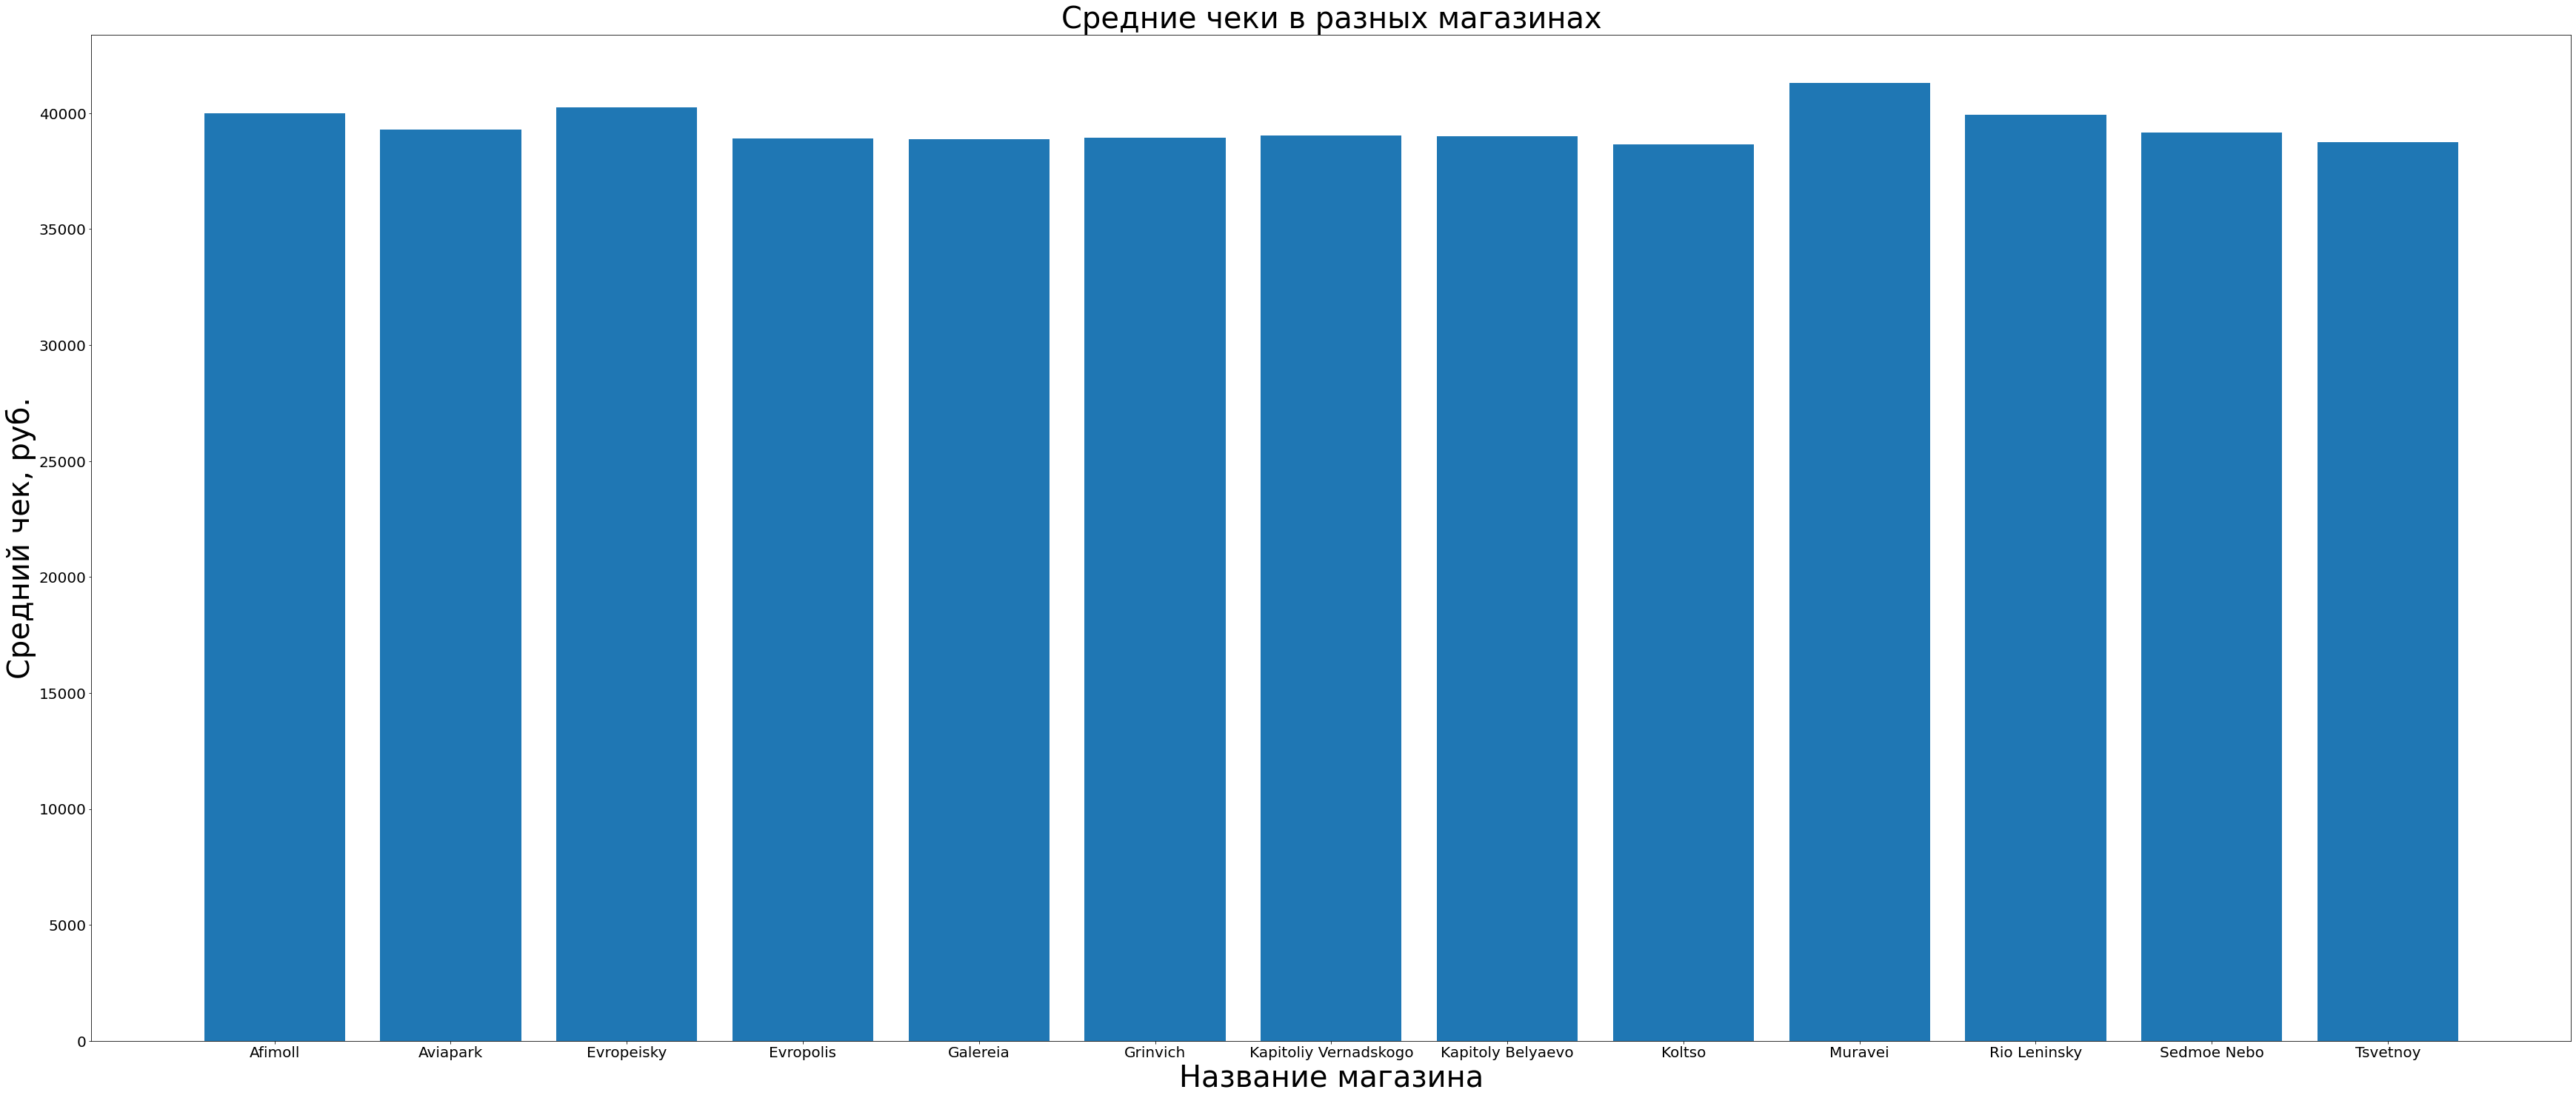

In [5]:
#Визуализируем распределение среднего чека по магазинам:
fig, ax = plt.subplots(figsize=(60, 25))
ax.bar(avg_order_shop['store_name'], avg_order_shop['prod_amount'])
ax.set_title('Средние чеки в разных магазинах', fontsize=40)
ax.set_xlabel('Название магазина', fontsize=40)
ax.set_ylabel('Средний чек, руб.', fontsize=40)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.show()

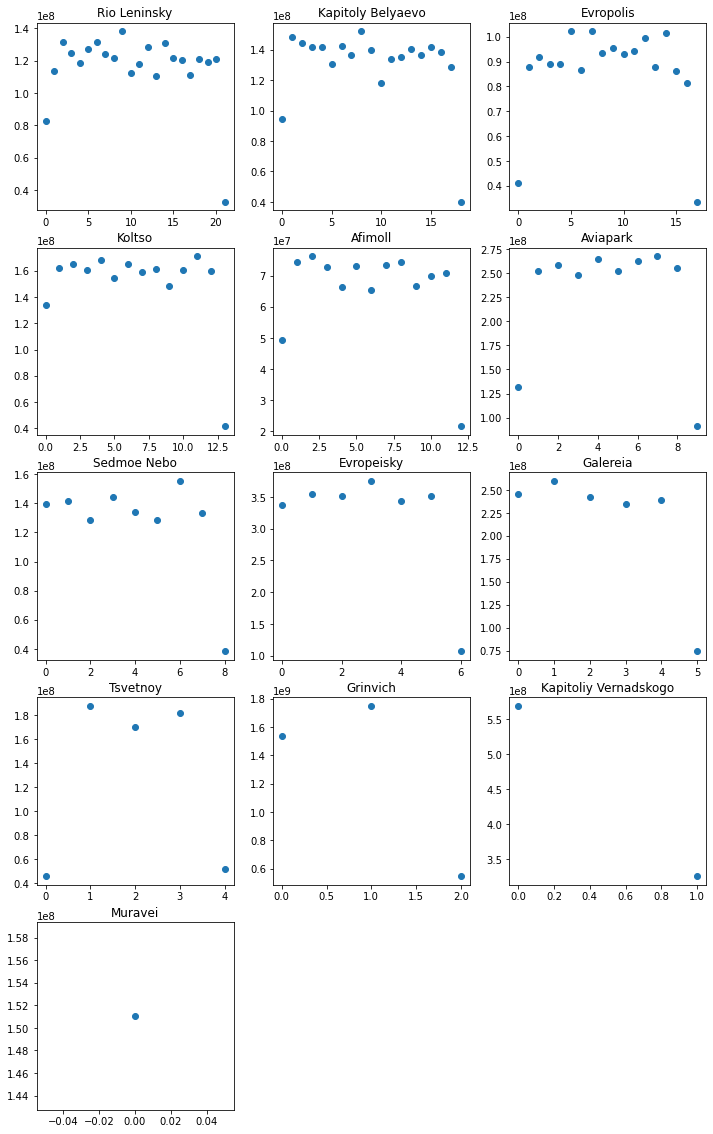

In [6]:
#Рассчитаем динамику продаж по месяцам с разбивкой по магазинам
orders['order_date'] = pd.to_datetime(orders['order_date'])
dynamic = orders.groupby([pd.Grouper(key='order_date', freq='M'), 'store_name'])['prod_amount'].sum().reset_index()
fig2 = plt.figure(figsize=(12, 20))
col = dynamic.store_name.unique().tolist()
for i in range(len(col)):
    fig2.add_subplot(5, 3, i+1)
    x = np.arange(len(dynamic[dynamic['store_name'] == col[i]]['order_date']))
    y = dynamic[dynamic['store_name'] == col[i]]['prod_amount']
    plt.title(col[i])
    plt.plot(x, y, 'o')
plt.show()

In [7]:
#Рассчитаем, какая часть пользователей делала покупки в наших магазинах 2 и более раз
ords = orders.groupby(['user_id', 'order_id'])['prod_amount'].sum().reset_index()
count_ord = ords.groupby('user_id')['order_id'].count().reset_index()
retention = round(len(count_ord[count_ord['order_id'] > 1]) / len(count_ord) * 100)
print(f'Всего {retention}% пользователей возвращаются в наш магазин после первой покупки')

Всего 100% пользователей возвращаются в наш магазин после первой покупки


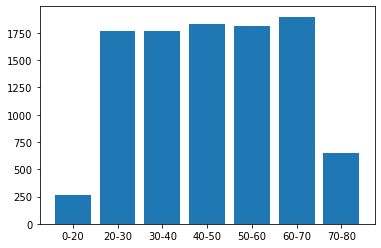

In [8]:
#Распределение клиентов по возрасту
user['age'] = round((pd.to_datetime('2024-01-20') - pd.to_datetime(user['user_birthdate'])) / pd.Timedelta(days=365.25))
bins = [0, 20, 30, 40, 50, 60, 70, 80]
labels = ['0-20', '20-30', '30-40', '40-50', '50-60', '60-70', '70-80']
categories = pd.cut(user['age'], bins=bins, labels=labels).reset_index()
gr = categories.groupby('age')['index'].count()
plt.bar(labels, gr)
plt.show()

In [9]:
# Процент возрата
cancellations_data = sales.groupby('is_canceled')['order_id'].count().reset_index()
refused = float(cancellations_data[cancellations_data['is_canceled'] == True]['order_id'])
total = cancellations_data['order_id'].sum()
cancellations = refused / total
print(f'Процент возврата товаров - {round(cancellations, 2)}%')

Процент возврата товаров - 0.45%


In [10]:
#Посчитаем приток клиентов за последний месяц
orders['order_date'] = pd.to_datetime(orders['order_date'])
orders_sort = orders.sort_values(['user_id', 'order_date'])
orders_sort['order_number'] = orders_sort.groupby('user_id').cumcount() + 1


#Количество клиентов купивших у нас что-то в первый раз за последние 3 месяца
new_clients = orders_sort[(orders_sort['order_date'] >= orders_sort['order_date'].max() - pd.DateOffset(months=3)) 
                         & (orders_sort['order_number'] == 1)]['user_id'].nunique()
old_clients = orders_sort[orders_sort['order_date'] < orders_sort['order_date'].max() - pd.DateOffset(months=3)]['user_id'].nunique()
percent = new_clients / old_clients
print(f'Приток покупателей - {round(percent * 100)}%')


#Посчитаем отношение количества активных покупателей за последний месяц к общему количеству покупателей за всё время
active_clients = orders[orders['order_date'] >= orders_sort['order_date'].max() - pd.DateOffset(months=1)]['user_id'].nunique()
all_clients = orders['user_id'].nunique()
mau = active_clients / all_clients
print(f'Процент активных покупателей за последний месяц - {round(mau * 100)}%.')

Приток покупателей - 11%
Процент активных покупателей за последний месяц - 100%.


In [11]:
#Посчитаем top-10 самых покупаемых товаров
most_selling = orders.groupby('product_id')['count'].sum().reset_index().sort_values('count', ascending=False).reset_index(drop=True).head(10)
most_selling = pd.merge(most_selling, product, on='product_id')


#Посчитаем top-10 самых товаров которые приносят наибольшую прибыль
orders['revenue'] = orders['product_comission'] * orders['count']
most_profitable = orders.groupby('product_id')['revenue'].sum().reset_index().sort_values('revenue', ascending=False).reset_index(drop=True).head(10)
most_profitable = pd.merge(most_profitable, product, on='product_id')
most_profitable['revenue'] = most_profitable['revenue'].map('₽{:,d}'.format)

In [12]:
most_selling

,product_id,count,product_name,product_size,product_color
0,1766,731,Onyx Overdrive Overcoat,M,Orange
1,2081,685,Urban Utopia Utility Pants,XL,Red
2,3602,659,Mars Mist Military Jacket,XS,Blue
3,3317,641,Vanguard Verve Vest,S,Pink
4,318,640,Serenity Tee,S,Brown
5,44,630,Azure Bliss Jeans,XL,Yellow
6,2075,615,Urban Utopia Utility Pants,L,Purple
7,3613,615,Mars Mist Military Jacket,S,Green
8,2355,609,Radiant Raven Rugby Polo,S,Purple
9,2406,608,Astral Ascent Anorak,XS,Orange


In [13]:
most_profitable

,product_id,revenue,product_name,product_size,product_color
0,1766,"₽2,374,750",Onyx Overdrive Overcoat,M,Orange
1,1048,"₽2,368,585",Radiant Raven Culottes,M,Brown
2,2250,"₽2,053,880",Nomad Nebula Henley,M,White
3,1064,"₽2,035,285",Radiant Raven Culottes,XL,Yellow
4,3054,"₽2,023,575",Stellar Safari Shorts,XXL,Yellow
5,2355,"₽2,016,505",Radiant Raven Rugby Polo,S,Purple
6,2641,"₽2,013,680",Emberstone Expedition Epaulettes,XS,Red
7,2617,"₽1,997,480",Thunderstrike Tee,L,Pink
8,476,"₽1,955,340",Aurora Borealis Jacket,XXL,Orange
9,2226,"₽1,931,820",Nomad Nebula Henley,XS,Orange
